# Execution Environment Notebook

## Introduction

This notebook aims to demonstrate and validate the execution environment isolation for the memory consumption experiment.
The goals of this notebooks are:

- Check if the experiment runs in an isolated process or container.
- Confirm that no memory contamination occurs between runs.

### How to Use this Notebook

- Run the individual cells to inspect and verify the behavior of specific parts of the component.
- Review the expected behavior before running the full experiment via the shell script.
- Use this notebook as a debugging and documentation tool to support future iterations of the experiment.

By structuring the experiment this way, we ensure a clear separation between explanation, validation, and execution, making it easier to reason about the results while keeping the experiment reproducible and well-documented.

## Components Overview

Before running the component, we need to setup a few variables and utils.

In [1]:
import os
import sys
from datetime import datetime

from loguru import logger

dirs_to_add = [
    os.path.abspath('../'),
]

for dir_to_add in dirs_to_add:
    if dir_to_add not in sys.path:
        sys.path.insert(0, dir_to_add)

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

EXPERIMENT_IMAGE = "mac/02-execution-environment"
RELATIVE_OUT_DIR = f"out/02-execution-environment-{TIMESTAMP}"
CONTAINER_OUT_DIR = f"/app/{RELATIVE_OUT_DIR}"
MEMORY_USAGE_DATA_GENERATION_LOG_FILE = f"{CONTAINER_OUT_DIR}/docker-monitor/memory-usage--data-generation.log"
MEMORY_USAGE_EXPERIMENT_LOG_FILE = f"{CONTAINER_OUT_DIR}/docker-monitor/memory-usage--experiment.log"
PAGE_FAULTS_DATA_GENERATION_LOG_FILE = f"{CONTAINER_OUT_DIR}/docker-monitor/page-faults--data-generation.log"
PAGE_FAULTS_EXPERIMENT_LOG_FILE = f"{CONTAINER_OUT_DIR}/docker-monitor/page-faults--experiment.log"

INLINES = "700"
XLINES = "700"
SAMPLES = "400"

logger.debug("Generated global variables")
logger.debug(f"TIMESTAMP: {TIMESTAMP}")
logger.debug(f"EXPERIMENT_IMAGE: {EXPERIMENT_IMAGE}")
logger.debug(f"RELATIVE_OUT_DIR: {RELATIVE_OUT_DIR}")
logger.debug(f"CONTAINER_OUT_DIR: {CONTAINER_OUT_DIR}")

logger.debug(f"MEMORY_USAGE_DATA_GENERATION_LOG_FILE: {MEMORY_USAGE_DATA_GENERATION_LOG_FILE}")
logger.debug(f"MEMORY_USAGE_EXPERIMENT_LOG_FILE: {MEMORY_USAGE_EXPERIMENT_LOG_FILE}")

logger.debug(f"PAGE_FAULTS_DATA_GENERATION_LOG_FILE: {PAGE_FAULTS_DATA_GENERATION_LOG_FILE}")
logger.debug(f"PAGE_FAULTS_EXPERIMENT_LOG_FILE: {PAGE_FAULTS_EXPERIMENT_LOG_FILE}")

logger.debug(f"INLINES: {INLINES}")
logger.debug(f"XLINES: {XLINES}")
logger.debug(f"SAMPLES: {SAMPLES}")

os.makedirs(f"../{RELATIVE_OUT_DIR}/docker-monitor", exist_ok=True)

2025-03-02 00:32:11.318 | DEBUG    | __main__:<module>:29 - Generated global variables
2025-03-02 00:32:11.318 | DEBUG    | __main__:<module>:30 - TIMESTAMP: 20250302003211
2025-03-02 00:32:11.318 | DEBUG    | __main__:<module>:31 - EXPERIMENT_IMAGE: mac/02-execution-environment
2025-03-02 00:32:11.318 | DEBUG    | __main__:<module>:32 - RELATIVE_OUT_DIR: out/02-execution-environment-20250302003211
2025-03-02 00:32:11.319 | DEBUG    | __main__:<module>:33 - CONTAINER_OUT_DIR: /app/out/02-execution-environment-20250302003211
2025-03-02 00:32:11.319 | DEBUG    | __main__:<module>:35 - MEMORY_USAGE_DATA_GENERATION_LOG_FILE: /app/out/02-execution-environment-20250302003211/docker-monitor/memory-usage--data-generation.log
2025-03-02 00:32:11.319 | DEBUG    | __main__:<module>:36 - MEMORY_USAGE_EXPERIMENT_LOG_FILE: /app/out/02-execution-environment-20250302003211/docker-monitor/memory-usage--experiment.log
2025-03-02 00:32:11.319 | DEBUG    | __main__:<module>:38 - PAGE_FAULTS_DATA_GENERATIO

Now, let's build the Docker images

In [2]:
import docker

from loguru import logger

client = docker.from_env()

logger.info("Building experiment image...")
experiment_image_build = client.images.build(
    path="../",
    tag=EXPERIMENT_IMAGE,
)
logger.info("Experiment image built successfully.")

2025-03-02 00:32:11.391 | INFO     | __main__:<module>:7 - Building experiment image...
2025-03-02 00:32:12.108 | INFO     | __main__:<module>:12 - Experiment image built successfully.


With the images built, we're going to generate the test data.

In [3]:
logger.info("Generating test data...")
data_generator_container = client.containers.run(
    image=EXPERIMENT_IMAGE,
    command=[
        "generate-data",
        "--inlines", INLINES,
        "--xlines", XLINES,
        "--samples", SAMPLES,
        "--output-dir", f"{CONTAINER_OUT_DIR}/data"
    ],
    environment={
        "MEMORY_USAGE_LOG_FILE": MEMORY_USAGE_DATA_GENERATION_LOG_FILE,
        "PAGE_FAULTS_LOG_FILE": PAGE_FAULTS_DATA_GENERATION_LOG_FILE,
        "PAGE_FAULTS_MONITORED_PROCESS_NAME": "main.py generate-data",
    },
    volumes={
        os.path.abspath(f"../{RELATIVE_OUT_DIR}"): {
            "bind": CONTAINER_OUT_DIR,
            "mode": "rw",
        }
    },
)
logger.info("Finished generating test data")


2025-03-02 00:32:12.193 | INFO     | __main__:<module>:1 - Generating test data...
2025-03-02 00:33:04.118 | INFO     | __main__:<module>:23 - Finished generating test data


With the test data generated, we're going to execute the experiment, and launch the Docker monitor to check the memory usage.

In [4]:
logger.info("Launching experiment...")
experiment_container = client.containers.run(
    image=EXPERIMENT_IMAGE,
    mem_limit="15g",
    command=[
        "operate",
        "envelope",
        "--segy-path", f"{CONTAINER_OUT_DIR}/data/{INLINES}-{XLINES}-{SAMPLES}.segy"
    ],
    environment={
        "MEMORY_USAGE_LOG_FILE": MEMORY_USAGE_EXPERIMENT_LOG_FILE,
        "PAGE_FAULTS_LOG_FILE": PAGE_FAULTS_EXPERIMENT_LOG_FILE,
        "PAGE_FAULTS_MONITORED_PROCESS_NAME": "main.py operate",
    },
    volumes={
        os.path.abspath(f"../{RELATIVE_OUT_DIR}"): {
            "bind": CONTAINER_OUT_DIR,
            "mode": "rw",
        }
    },
)
logger.info("Finished executing experiment")

2025-03-02 00:33:04.139 | INFO     | __main__:<module>:1 - Launching experiment...
2025-03-02 00:33:08.960 | INFO     | __main__:<module>:22 - Finished executing experiment


After executing the experiment, now we need to parse the memory usage data.

In [5]:
import importlib
import tools.monitor

importlib.reload(tools.monitor)

memory_usage_df = tools.monitor.memory_usage_log_to_df(
    f"../{RELATIVE_OUT_DIR}/docker-monitor/memory-usage--experiment.log",
)

memory_usage_df.head()

2025-03-02 00:33:08.973 | INFO     | tools.monitor:memory_usage_log_to_df:8 - Reading memory usage log) file: ../out/02-execution-environment-20250302003211/docker-monitor/memory-usage--experiment.log


,timestamp,memory_usage_kb
0,2025-03-02 03:33:05.360,25108
1,2025-03-02 03:33:05.569,44992
2,2025-03-02 03:33:05.780,63536
3,2025-03-02 03:33:05.983,90772
4,2025-03-02 03:33:06.190,656032


In [6]:
import tools.conversions

importlib.reload(tools.conversions)

peak_memory_usage = tools.conversions.kb_to_gb(
    memory_usage_df["memory_usage_kb"].max()
)

logger.info("Peak memory usage: {} GB".format(peak_memory_usage))

2025-03-02 00:33:09.023 | INFO     | __main__:<module>:9 - Peak memory usage: 5.596973419189453 GB


Given that we know that the memory usage data is correct, we will now execute multiple iterations to confirm that the memory usage is consistent.

In [7]:
iterations = 30

memory_usage_history = []
page_faults_history = []

peak_memory_usage_history = []
peak_minor_page_faults_history = []
peak_major_page_faults_history = []

for i in range(iterations):
    memory_usage_log_file = f"docker-monitor/memory-usage--experiment-{i}.log"
    page_faults_log_file = f"docker-monitor/page-faults--experiment-{i}.log"

    logger.info(f"Iteration {i + 1}/{iterations}")
    experiment_container = client.containers.run(
        image=EXPERIMENT_IMAGE,
        mem_limit="15g",
        auto_remove=True,
        command=[
            "operate",
            "envelope",
            "--segy-path", f"{CONTAINER_OUT_DIR}/data/{INLINES}-{XLINES}-{SAMPLES}.segy"
        ],
        environment={
            "MEMORY_USAGE_LOG_FILE": f"{CONTAINER_OUT_DIR}/{memory_usage_log_file}",
            "PAGE_FAULTS_LOG_FILE": f"{CONTAINER_OUT_DIR}/{page_faults_log_file}",
            "PAGE_FAULTS_MONITORED_PROCESS_NAME": "main.py operate",
        },
        volumes={
            os.path.abspath(f"../{RELATIVE_OUT_DIR}"): {
                "bind": CONTAINER_OUT_DIR,
                "mode": "rw",
            }
        },
    )

    memory_usage_df = tools.monitor.memory_usage_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{memory_usage_log_file}",
    )
    page_faults_df = tools.monitor.page_faults_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{page_faults_log_file}",
    )

    peak_memory_usage = tools.conversions.kb_to_gb(
        memory_usage_df["memory_usage_kb"].max()
    )
    peak_minor_page_faults = page_faults_df["minor_page_faults"].max()
    peak_major_page_faults = page_faults_df["major_page_faults"].max()

    memory_usage_history.append(memory_usage_df)
    page_faults_history.append(page_faults_df)

    peak_memory_usage_history.append(peak_memory_usage)
    peak_minor_page_faults_history.append(peak_minor_page_faults)
    peak_major_page_faults_history.append(peak_major_page_faults)

    logger.info("Peak memory usage: {} GB".format(peak_memory_usage))
    logger.info("Peak minor page faults: {}".format(peak_minor_page_faults))
    logger.info("Peak major page faults: {}".format(peak_major_page_faults))

2025-03-02 00:33:09.067 | INFO     | __main__:<module>:14 - Iteration 1/30
2025-03-02 00:33:14.317 | INFO     | tools.monitor:memory_usage_log_to_df:8 - Reading memory usage log) file: ../out/02-execution-environment-20250302003211/docker-monitor/memory-usage--experiment-0.log
2025-03-02 00:33:14.318 | INFO     | tools.monitor:page_faults_log_to_df:28 - Reading page faults log file: ../out/02-execution-environment-20250302003211/docker-monitor/page-faults--experiment-0.log
2025-03-02 00:33:14.318 | INFO     | __main__:<module>:57 - Peak memory usage: 5.347404479980469 GB
2025-03-02 00:33:14.319 | INFO     | __main__:<module>:58 - Peak minor page faults: 761253
2025-03-02 00:33:14.319 | INFO     | __main__:<module>:59 - Peak major page faults: 192
2025-03-02 00:33:14.319 | INFO     | __main__:<module>:14 - Iteration 2/30
2025-03-02 00:33:19.462 | INFO     | tools.monitor:memory_usage_log_to_df:8 - Reading memory usage log) file: ../out/02-execution-environment-20250302003211/docker-moni

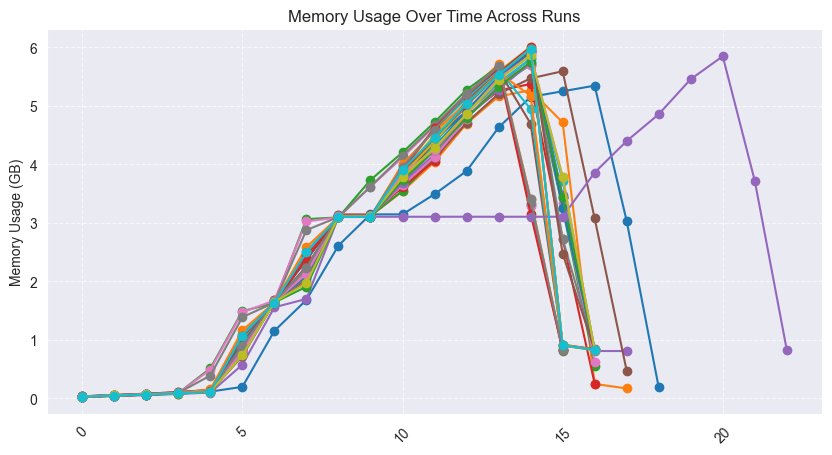

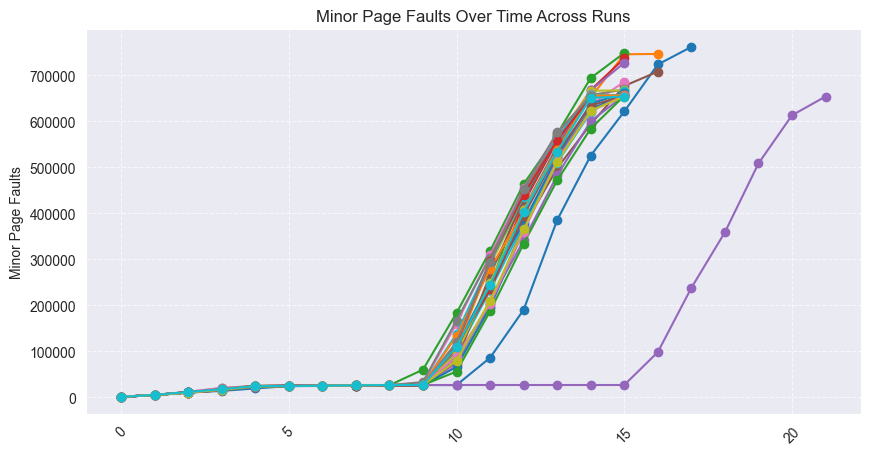

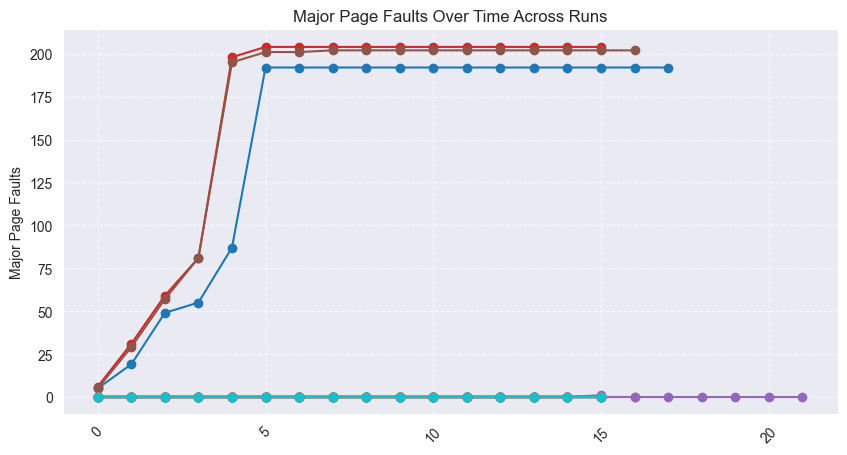

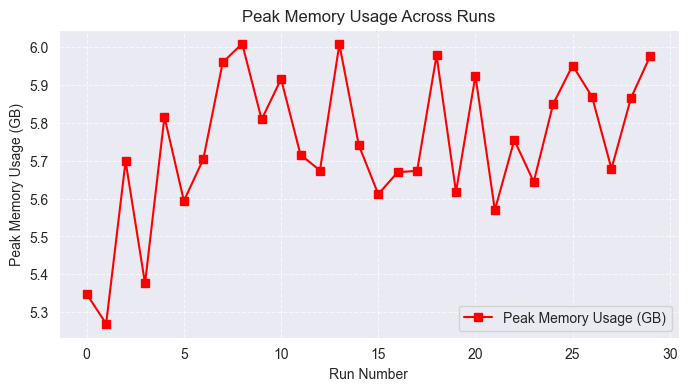

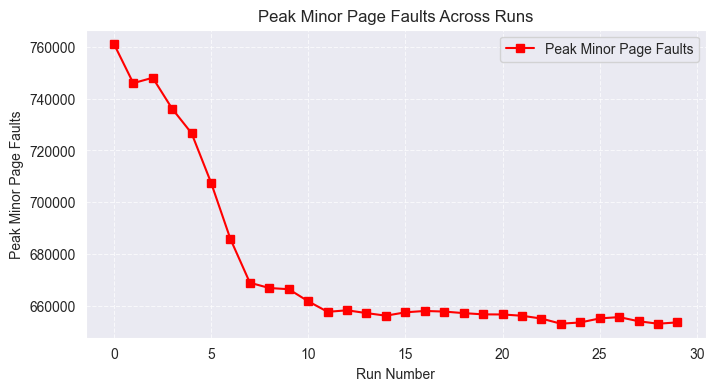

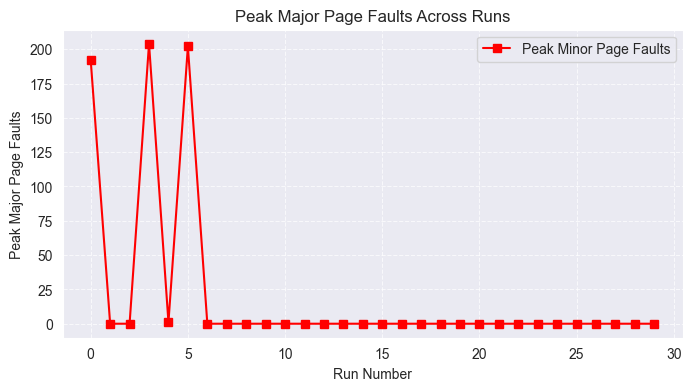

In [8]:
import matplotlib.pyplot as plt

# Plot memory usage over time for all DataFrames
plt.figure(figsize=(10, 5))
for i, df in enumerate(memory_usage_history):
    memory_usages = tools.conversions.kb_to_gb(df["memory_usage_kb"]).to_numpy()
    plt.plot(memory_usages, marker='o', linestyle='-', label=f'Run {i + 1}')

plt.ylabel("Memory Usage (GB)")
plt.title("Memory Usage Over Time Across Runs")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot minor page faults over time for all DataFrames
plt.figure(figsize=(10, 5))
for i, df in enumerate(page_faults_history):
    minor_page_faults = df["minor_page_faults"].to_numpy()
    plt.plot(minor_page_faults, marker='o', linestyle='-', label=f'Run {i + 1}')

plt.ylabel("Minor Page Faults")
plt.title("Minor Page Faults Over Time Across Runs")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot major page faults over time for all DataFrames
plt.figure(figsize=(10, 5))
for i, df in enumerate(page_faults_history):
    major_page_faults = df["major_page_faults"].to_numpy()
    plt.plot(major_page_faults, marker='o', linestyle='-', label=f'Run {i + 1}')

plt.ylabel("Major Page Faults")
plt.title("Major Page Faults Over Time Across Runs")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot peak memory usage across runs
plt.figure(figsize=(8, 4))
plt.plot(peak_memory_usage_history, marker='s', linestyle='-', color='r', label='Peak Memory Usage (GB)')
plt.xlabel("Run Number")
plt.ylabel("Peak Memory Usage (GB)")
plt.title("Peak Memory Usage Across Runs")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot peak minor page faults across runs
plt.figure(figsize=(8, 4))
plt.plot(peak_minor_page_faults_history, marker='s', linestyle='-', color='r', label='Peak Minor Page Faults')
plt.xlabel("Run Number")
plt.ylabel("Peak Minor Page Faults")
plt.title("Peak Minor Page Faults Across Runs")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot peak major page faults across runs
plt.figure(figsize=(8, 4))
plt.plot(peak_major_page_faults_history, marker='s', linestyle='-', color='r', label='Peak Minor Page Faults')
plt.xlabel("Run Number")
plt.ylabel("Peak Major Page Faults")
plt.title("Peak Major Page Faults Across Runs")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

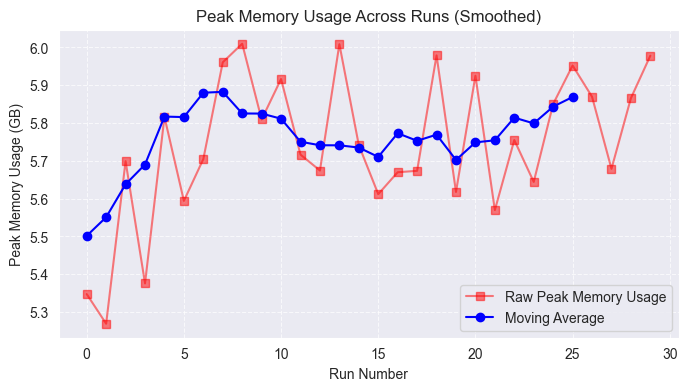

In [9]:
import numpy as np

# Plot moving average of peak memory usage
window_size = 5
moving_avg = np.convolve(peak_memory_usage_history, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(8, 4))
plt.plot(peak_memory_usage_history, marker='s', linestyle='-', color='r', alpha=0.5, label='Raw Peak Memory Usage')
plt.plot(range(len(moving_avg)), moving_avg, marker='o', linestyle='-', color='b', label='Moving Average')
plt.xlabel("Run Number")
plt.ylabel("Peak Memory Usage (GB)")
plt.title("Peak Memory Usage Across Runs (Smoothed)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

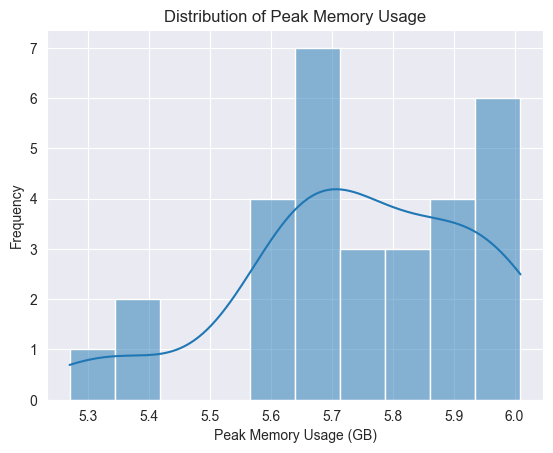

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of peak memory usage
sns.histplot(peak_memory_usage_history, bins=10, kde=True)
plt.xlabel("Peak Memory Usage (GB)")
plt.ylabel("Frequency")
plt.title("Distribution of Peak Memory Usage")
plt.show()

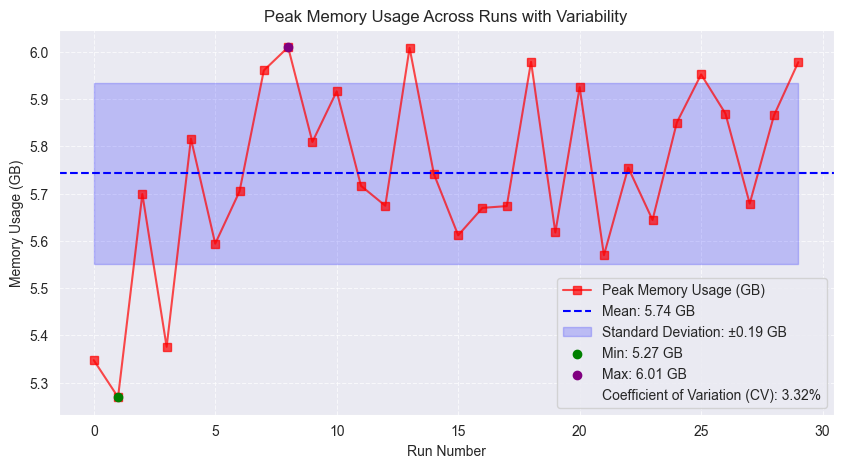

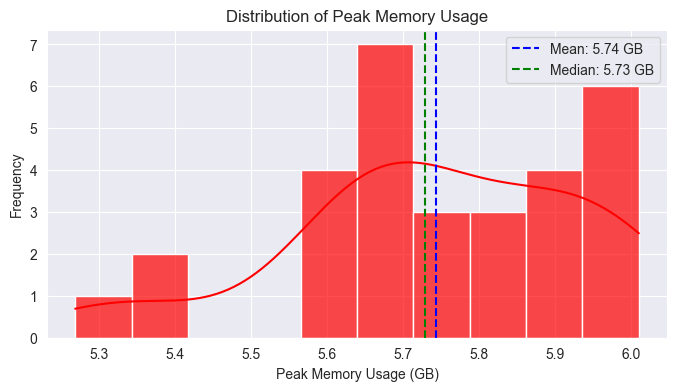

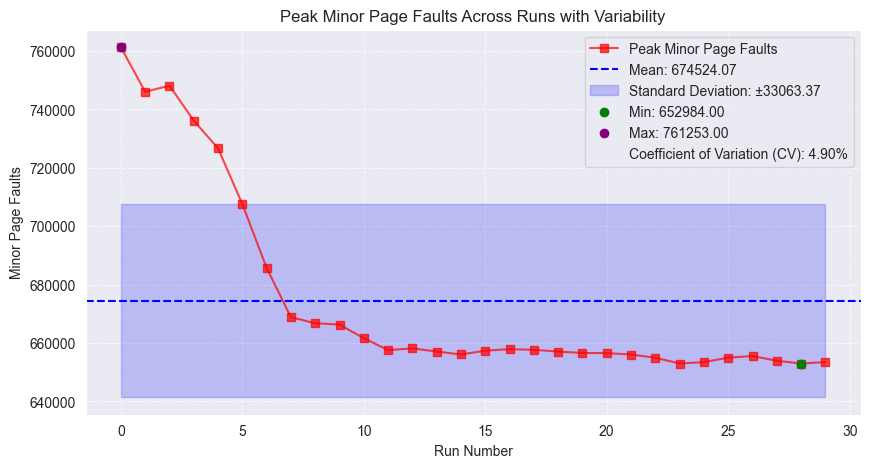

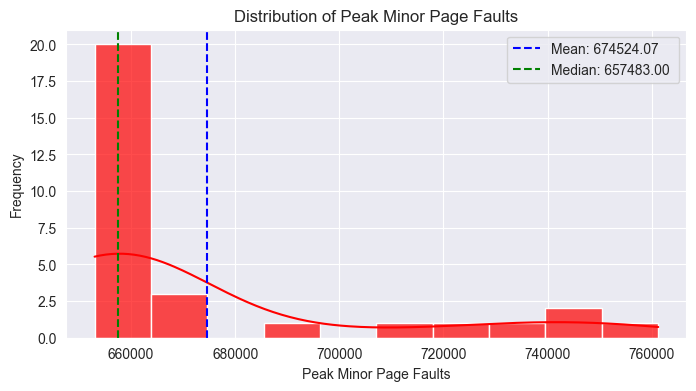

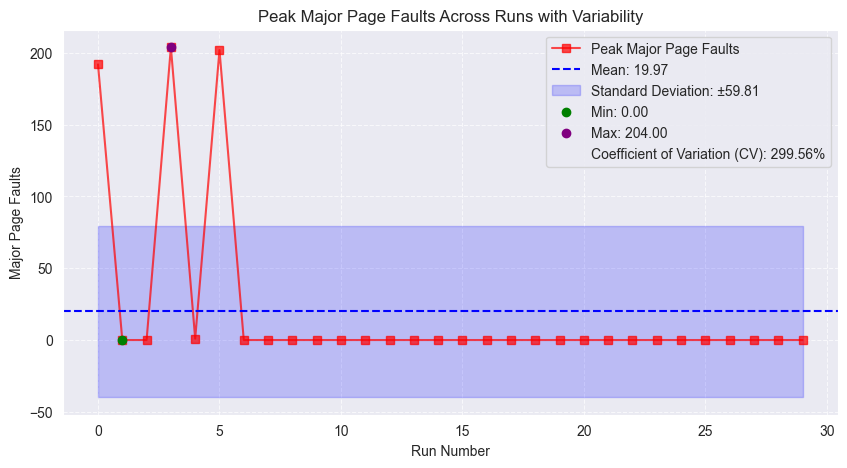

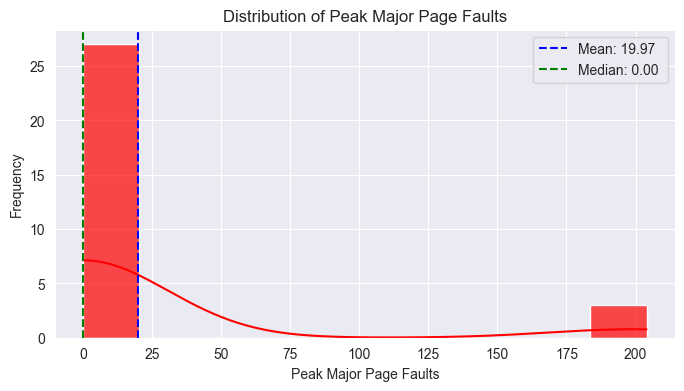

In [11]:
def plot_variability(peaks: list[float], metric: str, unit: str = ""):
    unit = unit.strip() if unit else ""
    metric_with_unit = f"{metric}{f' ({unit})' if unit != '' else ''}"

    mean_peak = np.mean(peaks)
    std_dev_peak = np.std(peaks)
    median_peak = np.median(peaks)
    min_peak = np.min(peaks)
    max_peak = np.max(peaks)
    coefficient_of_variation = (std_dev_peak / mean_peak) * 100

    # Create a figure to visualize peak memory usage and its variability
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot peak memory usage
    ax.plot(peaks, marker='s', linestyle='-', color='r', alpha=0.7, label=f"Peak {metric_with_unit}")

    # Plot mean and standard deviation bands
    ax.axhline(mean_peak, color='b', linestyle='--', label=f'Mean: {mean_peak:.2f} {unit}')
    ax.fill_between(range(len(peaks)), mean_peak - std_dev_peak, mean_peak + std_dev_peak,
                    color='blue', alpha=0.2, label=f'Standard Deviation: ±{std_dev_peak:.2f} {unit}')

    # Annotate min and max values
    ax.scatter(np.argmin(peaks), min_peak, color='green', label=f'Min: {min_peak:.2f} {unit}', zorder=3)
    ax.scatter(np.argmax(peaks), max_peak, color='purple', label=f'Max: {max_peak:.2f} {unit}', zorder=3)

    # Labels and title
    ax.set_xlabel("Run Number")
    ax.set_ylabel(metric_with_unit)
    ax.set_title(f"Peak {metric} Across Runs with Variability")
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.plot([], [], ' ', label=f'Coefficient of Variation (CV): {coefficient_of_variation:.2f}%')
    ax.legend()
    plt.show()

    # Histogram to visualize distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(peaks, bins=10, kde=True, color='r', alpha=0.7)
    plt.axvline(mean_peak, color='b', linestyle='--', label=f'Mean: {mean_peak:.2f} {unit}')
    plt.axvline(median_peak, color='g', linestyle='--', label=f'Median: {median_peak:.2f} {unit}')
    plt.xlabel(f"Peak {metric_with_unit}")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Peak {metric}")
    plt.legend()
    plt.show()


plot_variability(peak_memory_usage_history, "Memory Usage", "GB")
plot_variability(peak_minor_page_faults_history, "Minor Page Faults")
plot_variability(peak_major_page_faults_history, "Major Page Faults")



As we can see, for some reason even that we're running on Docker containers, we see a different memory usage pattern on the first runs, increasing after each iteration.
Also, we see that the amount of page faults decreases after each iteration.

This can be happening due to numerous reasons:

### JIT (Just-In-Time) Compilation
Since the code relies on libraries like NumPy or Pandas, these libraries may compile optimized code during the first run, leading to increased memory usage in subsequent runs.
The first run may be loading only necessary components, while subsequent runs may use cached compiled versions, leading to increased memory.

References:
- [Python 3.13 gets a JIT](https://tonybaloney.github.io/posts/python-gets-a-jit.html)

### Memory Fragmentation in Docker
Even though each run happens in an isolated Docker container, the underlying host OS manages memory allocation.
If the first container execution does not request a lot of memory, it may get a fresh, contiguous memory block.
Later executions might be assigned more fragmented memory, leading to slightly higher peak memory usage due to additional memory allocation overhead.

References:
- [Container memory usage keeps on increasing until it gets OOM killed](https://www.reddit.com/r/docker/comments/10rpdn3/container_memory_usage_keeps_on_increasing_until/)
- [Docker memory usage and how processes running inside containers see it](https://forums.docker.com/t/docker-memory-usage-and-how-processes-running-inside-containers-see-it/90660)
- [Memory not being cleared within Docker container after job is finished](https://github.com/agronholm/apscheduler/issues/600)

### Kernel Page Caching and OS-Level Effects
The Linux kernel aggressively caches frequently accessed data in RAM.
On the first run, the container might load libraries from disk (low memory usage).
On subsequent runs, those libraries and data might be cached in RAM, causing the OS to report a higher peak memory usage.

References:
- [Percent memory usage of containers after reboot](https://forums.docker.com/t/percent-memory-usage-of-containers-after-reboot/140668)
- [Docker memory usage hitting 100% and Unraid slow to respond](https://forums.unraid.net/topic/157432-docker-memory-usage-hitting-100-and-unraid-slow-to-respond/)


We have a few possible startegies to try to mitigate this issue:

1. Bypass page caching
2. Explicitly dropping page caching
3. Forcing GC to be used
4. Forcing the container to always use the same CPU

We will try those in sequence, until we find one that works.

We will start by trying to bypass page cache.
Docker provides the option to use the `vfs` storage driver, which does the following:

- Bypass page caching
- Prevents copy-on-write (COW) issues
- Is cross-platform
- Allows filesystem isolation

[Reference](https://docs.docker.com/engine/storage/drivers/vfs-driver/)

So, we're going to use `vfs` and test using it

2025-03-02 00:35:36.824 | INFO     | __main__:<module>:8 - Starting VFS Docker daemon...
2025-03-02 00:35:36.984 | INFO     | __main__:<module>:32 - Waiting for dockerd to start...
ERROR: error during connect: Get "http://localhost:2375/v1.47/info": read tcp [::1]:52095->[::1]:2375: read: connection reset by peer
errors pretty printing info
2025-03-02 00:35:42.069 | INFO     | __main__:<module>:41 - Waiting for dockerd to start...


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

ERROR: error during connect: Get "http://localhost:2375/v1.47/info": read tcp [::1]:52109->[::1]:2375: read: connection reset by peer
errors pretty printing info
2025-03-02 00:35:47.156 | INFO     | __main__:<module>:41 - Waiting for dockerd to start...


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

ERROR: error during connect: Get "http://localhost:2375/v1.47/info": read tcp [::1]:52118->[::1]:2375: read: connection reset by peer
errors pretty printing info
2025-03-02 00:35:52.247 | INFO     | __main__:<module>:41 - Waiting for dockerd to start...


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

[DEPRECATION NOTICE]: API is accessible on http://0.0.0.0:2375 without encryption.
         Access to the remote API is equivalent to root access on the host. Refer
         to the 'Docker daemon attack surface' section in the documentation for
         more information: https://docs.docker.com/go/attack-surface/
In future versions this will be a hard failure preventing the daemon from starting! Learn more at: https://docs.docker.com/go/api-security/
2025-03-02 00:35:57.317 | INFO     | __main__:<module>:38 - dockerd inside dind is fully operational.
2025-03-02 00:35:57.326 | INFO     | __main__:<module>:46 - Building experiment image...


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

2025-03-02 00:37:08.004 | INFO     | __main__:<module>:51 - Experiment image built successfully.
2025-03-02 00:37:08.007 | INFO     | __main__:<module>:66 - Iteration 1/30
2025-03-02 00:37:14.549 | INFO     | tools.monitor:memory_usage_log_to_df:8 - Reading memory usage log) file: ../out/02-execution-environment-20250302003211/docker-monitor/memory-usage--experiment-0-with-vfs.log
2025-03-02 00:37:14.552 | INFO     | tools.monitor:page_faults_log_to_df:28 - Reading page faults log file: ../out/02-execution-environment-20250302003211/docker-monitor/page-faults--experiment-0-with-vfs.log
2025-03-02 00:37:14.553 | INFO     | __main__:<module>:110 - Peak memory usage: 5.160846710205078 GB
2025-03-02 00:37:14.554 | INFO     | __main__:<module>:111 - Peak minor page faults: 1214229
2025-03-02 00:37:14.554 | INFO     | __main__:<module>:112 - Peak major page faults: 1
2025-03-02 00:37:14.555 | INFO     | __main__:<module>:66 - Iteration 2/30
2025-03-02 00:37:21.785 | INFO     | tools.monitor:

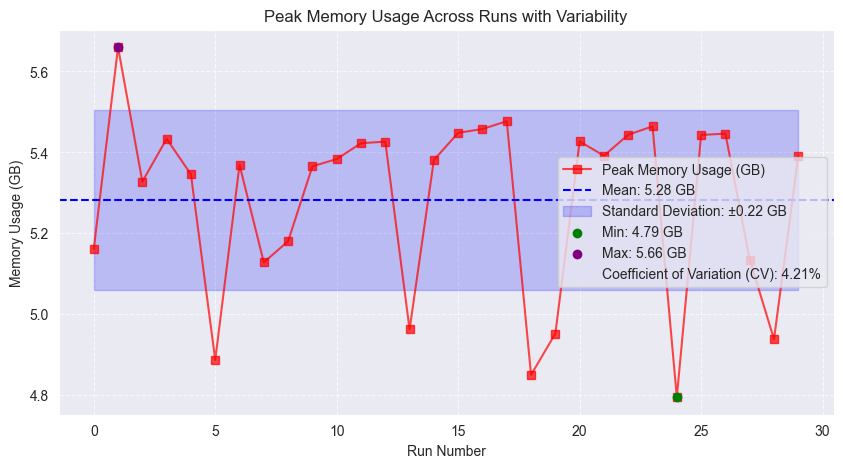

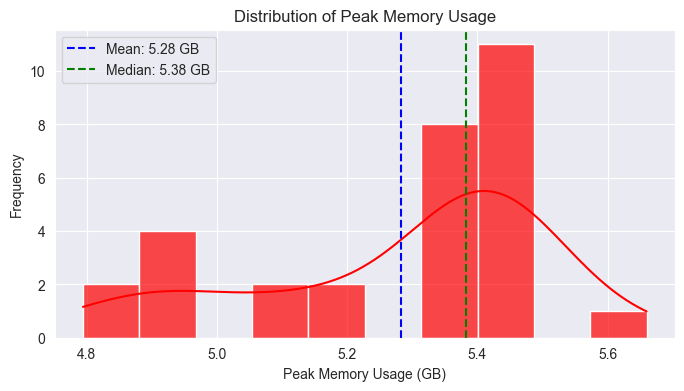

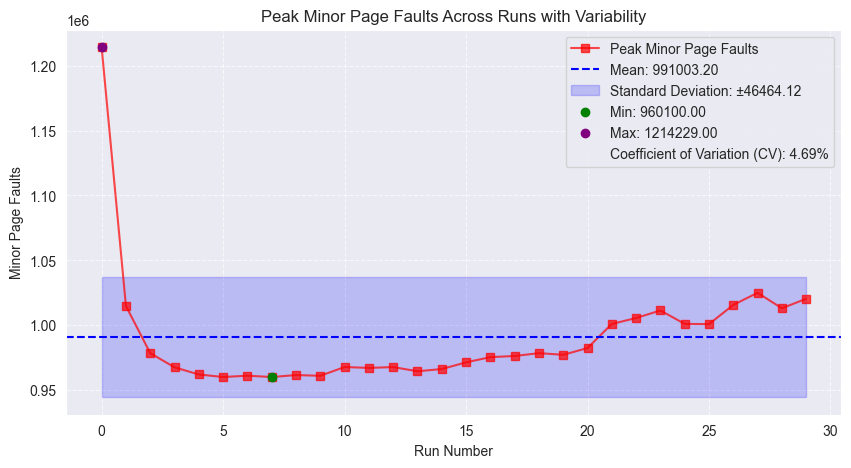

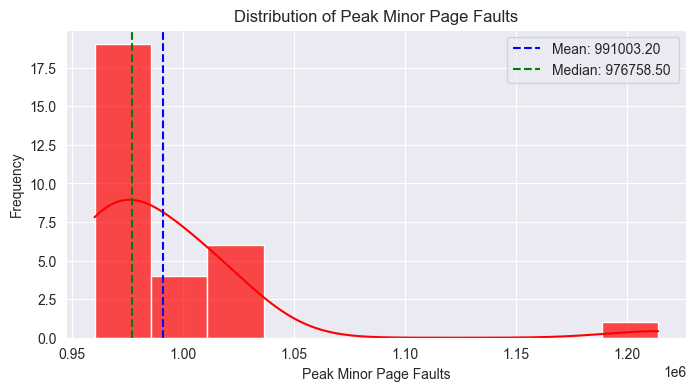

In [12]:
import subprocess
import time
import os

DIND_CONTAINER_NAME = "vfs-dind"
HOST_OUT_DIR = os.path.abspath(f"../{RELATIVE_OUT_DIR}")

logger.info("Starting VFS Docker daemon...")
vfs_container = client.containers.run(
    image="docker:dind",
    name=DIND_CONTAINER_NAME,
    auto_remove=True,
    privileged=True,
    detach=True,
    ports={
        "2375/tcp": 2375
    },
    command=[
        "--storage-driver=vfs"
    ],
    environment={
        "DOCKER_TLS_CERTDIR": "",
    },
    volumes={
        os.path.abspath(f"../{RELATIVE_OUT_DIR}"): {
            "bind": "/mnt/out",
            "mode": "rw",
        }
    },
)

logger.info("Waiting for dockerd to start...")
time.sleep(5)

for _ in range(10):
    try:
        subprocess.run(["docker", "-H", "tcp://localhost:2375", "info"], check=True)
        logger.info("dockerd inside dind is fully operational.")
        break
    except subprocess.CalledProcessError:
        logger.info("Waiting for dockerd to start...")
        time.sleep(5)

vfs_client = docker.DockerClient(base_url="tcp://localhost:2375")

logger.info("Building experiment image...")
experiment_image_build = vfs_client.images.build(
    path="../",
    tag=EXPERIMENT_IMAGE,
)
logger.info("Experiment image built successfully.")

iterations = 30

memory_usage_history = []
page_faults_history = []

peak_memory_usage_history = []
peak_minor_page_faults_history = []
peak_major_page_faults_history = []

for i in range(iterations):
    memory_usage_log_file = f"docker-monitor/memory-usage--experiment-{i}-with-vfs.log"
    page_faults_log_file = f"docker-monitor/page-faults--experiment-{i}-with-vfs.log"

    logger.info(f"Iteration {i + 1}/{iterations}")

    experiment_container = vfs_client.containers.run(
        image=EXPERIMENT_IMAGE,
        mem_limit="15g",
        auto_remove=True,
        command=[
            "operate",
            "envelope",
            "--segy-path", f"{CONTAINER_OUT_DIR}/data/{INLINES}-{XLINES}-{SAMPLES}.segy"
        ],
        environment={
            "MEMORY_USAGE_LOG_FILE": f"{CONTAINER_OUT_DIR}/{memory_usage_log_file}",
            "PAGE_FAULTS_LOG_FILE": f"{CONTAINER_OUT_DIR}/{page_faults_log_file}",
            "PAGE_FAULTS_MONITORED_PROCESS_NAME": "main.py operate",
        },
        volumes={
            "/mnt/out": {
                "bind": CONTAINER_OUT_DIR,
                "mode": "rw",
            }
        },
    )

    memory_usage_df = tools.monitor.memory_usage_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{memory_usage_log_file}",
    )
    page_faults_df = tools.monitor.page_faults_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{page_faults_log_file}",
    )

    peak_memory_usage = tools.conversions.kb_to_gb(
        memory_usage_df["memory_usage_kb"].max()
    )
    peak_minor_page_faults = page_faults_df["minor_page_faults"].max()
    peak_major_page_faults = page_faults_df["major_page_faults"].max()

    memory_usage_history.append(memory_usage_df)
    page_faults_history.append(page_faults_df)

    peak_memory_usage_history.append(peak_memory_usage)
    peak_minor_page_faults_history.append(peak_minor_page_faults)
    peak_major_page_faults_history.append(peak_major_page_faults)

    logger.info("Peak memory usage: {} GB".format(peak_memory_usage))
    logger.info("Peak minor page faults: {}".format(peak_minor_page_faults))
    logger.info("Peak major page faults: {}".format(peak_major_page_faults))

vfs_container.stop()

plot_variability(peak_memory_usage_history, "Memory Usage", "GB")
plot_variability(peak_minor_page_faults_history, "Minor Page Faults")

Based on the results, we can see that it wasn't effective.
We can still see the same pattern, of the page faults decreasing after the first few iterations.
We can now try explicitly dropping the page cache.

2025-03-02 00:40:43.466 | INFO     | __main__:<module>:24 - Starting VFS Docker daemon...
2025-03-02 00:40:51.921 | INFO     | __main__:<module>:48 - Waiting for dockerd to start...
ERROR: error during connect: Get "http://localhost:2375/v1.47/info": read tcp [::1]:52476->[::1]:2375: read: connection reset by peer
errors pretty printing info
2025-03-02 00:40:57.011 | INFO     | __main__:<module>:57 - Waiting for dockerd to start...


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

ERROR: error during connect: Get "http://localhost:2375/v1.47/info": read tcp [::1]:52485->[::1]:2375: read: connection reset by peer
errors pretty printing info
2025-03-02 00:41:02.103 | INFO     | __main__:<module>:57 - Waiting for dockerd to start...


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

ERROR: error during connect: Get "http://localhost:2375/v1.47/info": read tcp [::1]:52500->[::1]:2375: read: connection reset by peer
errors pretty printing info
2025-03-02 00:41:07.189 | INFO     | __main__:<module>:57 - Waiting for dockerd to start...


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

[DEPRECATION NOTICE]: API is accessible on http://0.0.0.0:2375 without encryption.
         Access to the remote API is equivalent to root access on the host. Refer
         to the 'Docker daemon attack surface' section in the documentation for
         more information: https://docs.docker.com/go/attack-surface/
In future versions this will be a hard failure preventing the daemon from starting! Learn more at: https://docs.docker.com/go/api-security/
2025-03-02 00:41:12.257 | INFO     | __main__:<module>:54 - dockerd inside dind is fully operational.
2025-03-02 00:41:12.263 | INFO     | __main__:<module>:62 - Building experiment image...


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

2025-03-02 00:42:20.741 | INFO     | __main__:<module>:67 - Experiment image built successfully.
2025-03-02 00:42:21.898 | INFO     | __main__:drop_caches_in_dind:18 - Dropped caches inside DinD container
2025-03-02 00:42:21.899 | INFO     | __main__:<module>:84 - Iteration 1/30
2025-03-02 00:42:29.286 | INFO     | tools.monitor:memory_usage_log_to_df:8 - Reading memory usage log) file: ../out/02-execution-environment-20250302003211/docker-monitor/memory-usage--experiment-0-without-page-caching.log
2025-03-02 00:42:29.287 | INFO     | tools.monitor:page_faults_log_to_df:28 - Reading page faults log file: ../out/02-execution-environment-20250302003211/docker-monitor/page-faults--experiment-0-without-page-caching.log
2025-03-02 00:42:29.288 | INFO     | __main__:<module>:128 - Peak memory usage: 5.211505889892578 GB
2025-03-02 00:42:29.289 | INFO     | __main__:<module>:129 - Peak minor page faults: 1025524
2025-03-02 00:42:29.289 | INFO     | __main__:<module>:130 - Peak major page faul

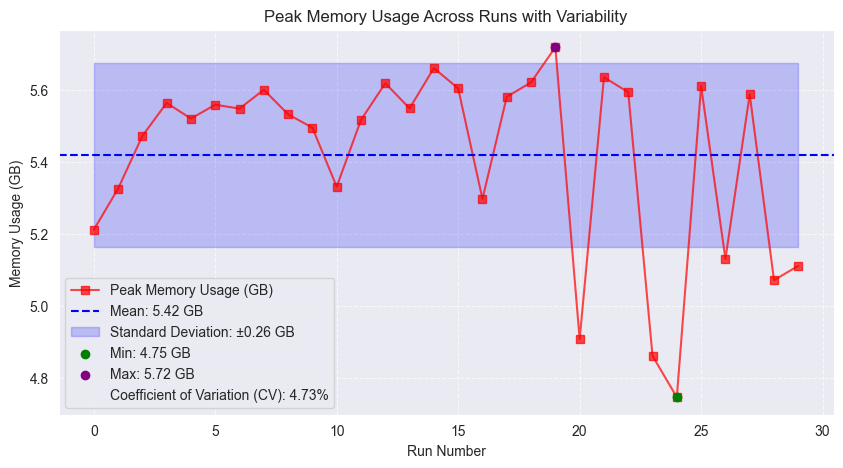

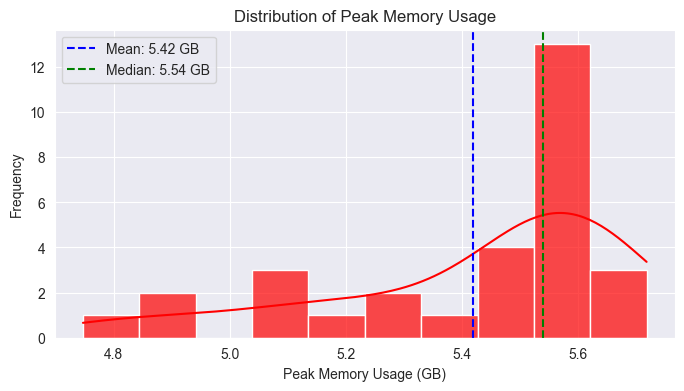

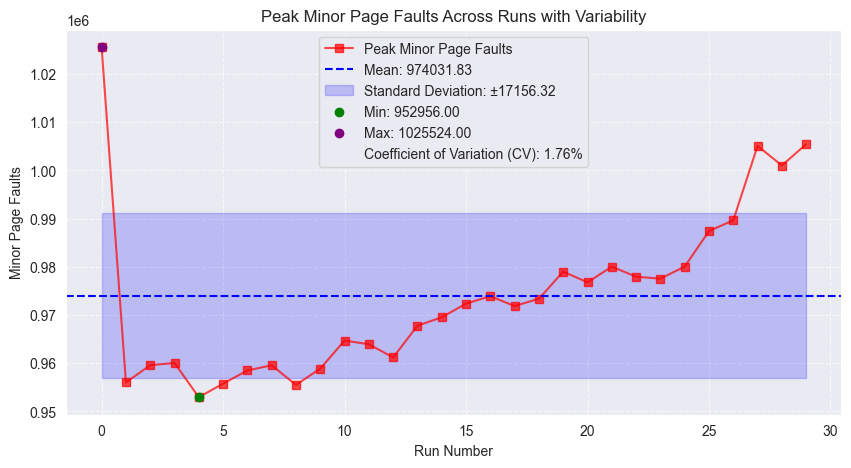

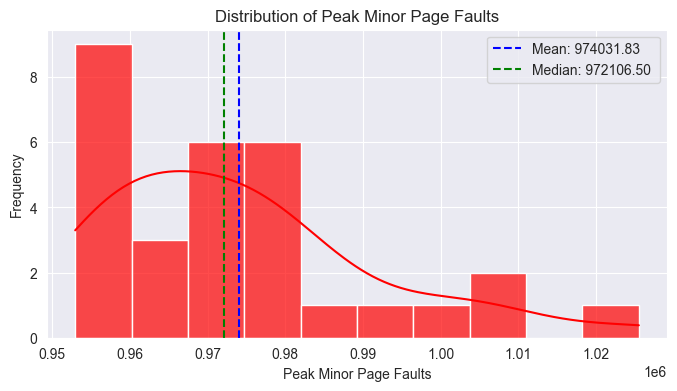

In [13]:
import subprocess
import time
import os


def drop_caches_in_dind():
    dind_container_id = subprocess.run(
        ["docker", "ps", "-q", "--filter", "ancestor=docker:dind"],
        capture_output=True, text=True
    ).stdout.strip()

    if not dind_container_id:
        logger.error("DinD container not found")
        return

    drop_cmd = f"docker exec {dind_container_id} sh -c 'sync && echo 3 > /proc/sys/vm/drop_caches'"
    subprocess.run(drop_cmd, shell=True, check=True)
    logger.info("Dropped caches inside DinD container")


DIND_CONTAINER_NAME = "vfs-dind"
HOST_OUT_DIR = os.path.abspath(f"../{RELATIVE_OUT_DIR}")

logger.info("Starting VFS Docker daemon...")
vfs_container = client.containers.run(
    image="docker:dind",
    name=DIND_CONTAINER_NAME,
    auto_remove=True,
    privileged=True,
    detach=True,
    ports={
        "2375/tcp": 2375
    },
    command=[
        "--storage-driver=vfs"
    ],
    environment={
        "DOCKER_TLS_CERTDIR": "",
    },
    volumes={
        os.path.abspath(f"../{RELATIVE_OUT_DIR}"): {
            "bind": "/mnt/out",
            "mode": "rw",
        }
    },
)

logger.info("Waiting for dockerd to start...")
time.sleep(5)

for _ in range(10):
    try:
        subprocess.run(["docker", "-H", "tcp://localhost:2375", "info"], check=True)
        logger.info("dockerd inside dind is fully operational.")
        break
    except subprocess.CalledProcessError:
        logger.info("Waiting for dockerd to start...")
        time.sleep(5)

vfs_client = docker.DockerClient(base_url="tcp://localhost:2375")

logger.info("Building experiment image...")
experiment_image_build = vfs_client.images.build(
    path="../",
    tag=EXPERIMENT_IMAGE,
)
logger.info("Experiment image built successfully.")

iterations = 30

memory_usage_history = []
page_faults_history = []

peak_memory_usage_history = []
peak_minor_page_faults_history = []
peak_major_page_faults_history = []

for i in range(iterations):
    memory_usage_log_file = f"docker-monitor/memory-usage--experiment-{i}-without-page-caching.log"
    page_faults_log_file = f"docker-monitor/page-faults--experiment-{i}-without-page-caching.log"

    drop_caches_in_dind()

    logger.info(f"Iteration {i + 1}/{iterations}")

    experiment_container = vfs_client.containers.run(
        image=EXPERIMENT_IMAGE,
        mem_limit="15g",
        auto_remove=True,
        command=[
            "operate",
            "envelope",
            "--segy-path", f"{CONTAINER_OUT_DIR}/data/{INLINES}-{XLINES}-{SAMPLES}.segy"
        ],
        environment={
            "MEMORY_USAGE_LOG_FILE": f"{CONTAINER_OUT_DIR}/{memory_usage_log_file}",
            "PAGE_FAULTS_LOG_FILE": f"{CONTAINER_OUT_DIR}/{page_faults_log_file}",
            "PAGE_FAULTS_MONITORED_PROCESS_NAME": "main.py operate",
        },
        volumes={
            "/mnt/out": {
                "bind": CONTAINER_OUT_DIR,
                "mode": "rw",
            }
        },
    )

    memory_usage_df = tools.monitor.memory_usage_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{memory_usage_log_file}",
    )
    page_faults_df = tools.monitor.page_faults_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{page_faults_log_file}",
    )

    peak_memory_usage = tools.conversions.kb_to_gb(
        memory_usage_df["memory_usage_kb"].max()
    )
    peak_minor_page_faults = page_faults_df["minor_page_faults"].max()
    peak_major_page_faults = page_faults_df["major_page_faults"].max()

    memory_usage_history.append(memory_usage_df)
    page_faults_history.append(page_faults_df)

    peak_memory_usage_history.append(peak_memory_usage)
    peak_minor_page_faults_history.append(peak_minor_page_faults)
    peak_major_page_faults_history.append(peak_major_page_faults)

    logger.info("Peak memory usage: {} GB".format(peak_memory_usage))
    logger.info("Peak minor page faults: {}".format(peak_minor_page_faults))
    logger.info("Peak major page faults: {}".format(peak_major_page_faults))

vfs_container.stop()

plot_variability(peak_memory_usage_history, "Memory Usage", "GB")
plot_variability(peak_minor_page_faults_history, "Minor Page Faults")

As we can see, dropping the page cache changed the pattern.
We don't see any specific pattern of the page faults dropping after the first few runs.
Now, we will try to force the garbage collector to run.

2025-03-02 00:46:08.312 | INFO     | __main__:<module>:16 - Iteration 1/30
2025-03-02 00:46:16.007 | INFO     | tools.monitor:memory_usage_log_to_df:8 - Reading memory usage log) file: ../out/02-execution-environment-20250302003211/docker-monitor/memory-usage--experiment-0-garbage-collected.log
2025-03-02 00:46:16.009 | INFO     | tools.monitor:page_faults_log_to_df:28 - Reading page faults log file: ../out/02-execution-environment-20250302003211/docker-monitor/page-faults--experiment-0-garbage-collected.log
2025-03-02 00:46:16.011 | INFO     | __main__:<module>:62 - Peak memory usage: 5.7535247802734375 GB
2025-03-02 00:46:16.012 | INFO     | __main__:<module>:63 - Peak minor page faults: 843643
2025-03-02 00:46:16.012 | INFO     | __main__:<module>:64 - Peak major page faults: 444
2025-03-02 00:46:16.012 | INFO     | __main__:<module>:16 - Iteration 2/30
2025-03-02 00:46:21.629 | INFO     | tools.monitor:memory_usage_log_to_df:8 - Reading memory usage log) file: ../out/02-execution-e

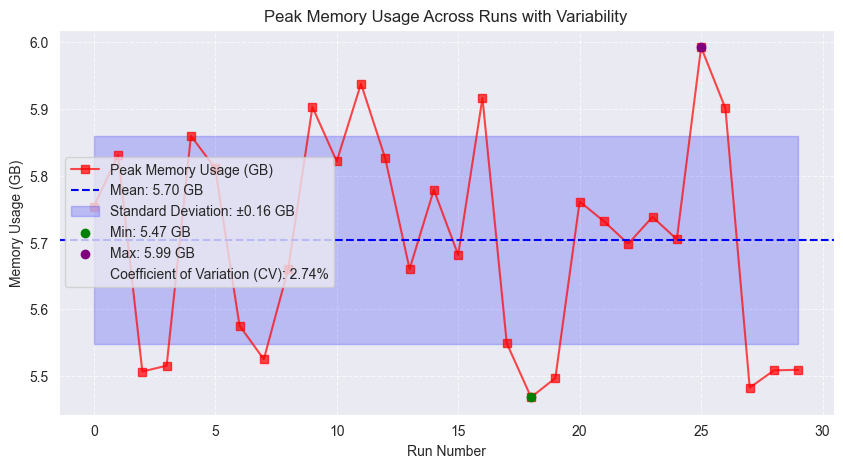

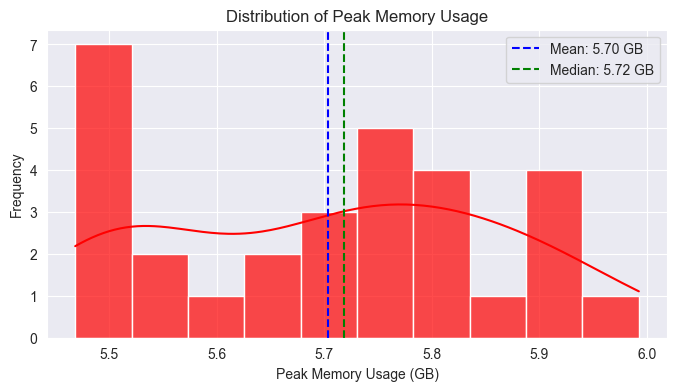

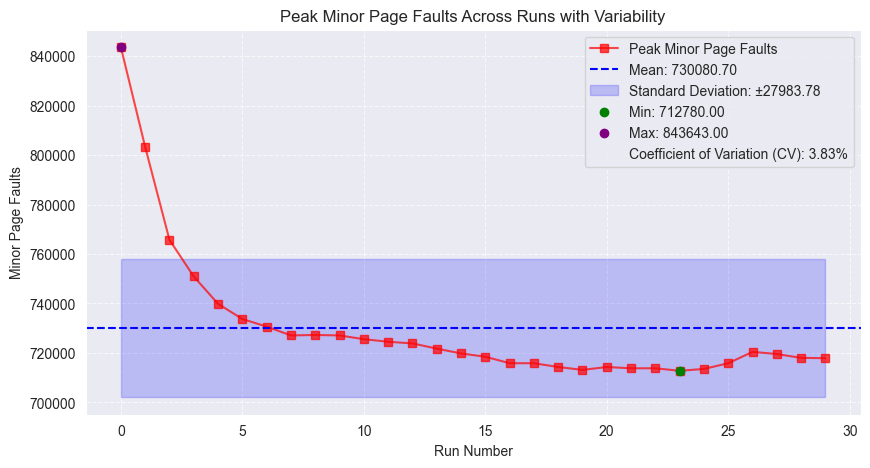

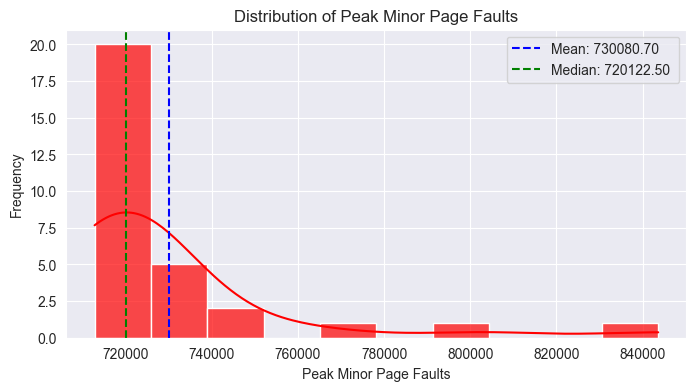

In [14]:
import gc

iterations = 30

memory_usage_history = []
page_faults_history = []

peak_memory_usage_history = []
peak_minor_page_faults_history = []
peak_major_page_faults_history = []

for i in range(iterations):
    memory_usage_log_file = f"docker-monitor/memory-usage--experiment-{i}-garbage-collected.log"
    page_faults_log_file = f"docker-monitor/page-faults--experiment-{i}-garbage-collected.log"

    logger.info(f"Iteration {i + 1}/{iterations}")

    gc.collect()

    experiment_container = client.containers.run(
        image=EXPERIMENT_IMAGE,
        mem_limit="15g",
        auto_remove=True,
        command=[
            "operate",
            "envelope",
            "--segy-path", f"{CONTAINER_OUT_DIR}/data/{INLINES}-{XLINES}-{SAMPLES}.segy"
        ],
        environment={
            "MEMORY_USAGE_LOG_FILE": f"{CONTAINER_OUT_DIR}/{memory_usage_log_file}",
            "PAGE_FAULTS_LOG_FILE": f"{CONTAINER_OUT_DIR}/{page_faults_log_file}",
            "PAGE_FAULTS_MONITORED_PROCESS_NAME": "main.py operate",
        },
        volumes={
            os.path.abspath(f"../{RELATIVE_OUT_DIR}"): {
                "bind": CONTAINER_OUT_DIR,
                "mode": "rw",
            }
        },
    )

    memory_usage_df = tools.monitor.memory_usage_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{memory_usage_log_file}",
    )
    page_faults_df = tools.monitor.page_faults_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{page_faults_log_file}",
    )

    peak_memory_usage = tools.conversions.kb_to_gb(
        memory_usage_df["memory_usage_kb"].max()
    )
    peak_minor_page_faults = page_faults_df["minor_page_faults"].max()
    peak_major_page_faults = page_faults_df["major_page_faults"].max()

    memory_usage_history.append(memory_usage_df)
    page_faults_history.append(page_faults_df)

    peak_memory_usage_history.append(peak_memory_usage)
    peak_minor_page_faults_history.append(peak_minor_page_faults)
    peak_major_page_faults_history.append(peak_major_page_faults)

    logger.info("Peak memory usage: {} GB".format(peak_memory_usage))
    logger.info("Peak minor page faults: {}".format(peak_minor_page_faults))
    logger.info("Peak major page faults: {}".format(peak_major_page_faults))

plot_variability(peak_memory_usage_history, "Memory Usage", "GB")
plot_variability(peak_minor_page_faults_history, "Minor Page Faults")

Manually calling the GC still doesn't change the page fault pattern.
Let's try making the CPU usage more strict to see if we can make the memory usage pattern more stable.

2025-03-02 00:48:46.379 | INFO     | __main__:<module>:14 - Iteration 1/30
2025-03-02 00:48:51.412 | INFO     | tools.monitor:memory_usage_log_to_df:8 - Reading memory usage log) file: ../out/02-execution-environment-20250302003211/docker-monitor/memory-usage--experiment-0-cpu-affinity.log
2025-03-02 00:48:51.412 | INFO     | tools.monitor:page_faults_log_to_df:28 - Reading page faults log file: ../out/02-execution-environment-20250302003211/docker-monitor/page-faults--experiment-0-cpu-affinity.log
2025-03-02 00:48:51.413 | INFO     | __main__:<module>:60 - Peak memory usage: 5.933189392089844 GB
2025-03-02 00:48:51.414 | INFO     | __main__:<module>:61 - Peak minor page faults: 718855
2025-03-02 00:48:51.414 | INFO     | __main__:<module>:62 - Peak major page faults: 0
2025-03-02 00:48:51.414 | INFO     | __main__:<module>:14 - Iteration 2/30
2025-03-02 00:48:56.646 | INFO     | tools.monitor:memory_usage_log_to_df:8 - Reading memory usage log) file: ../out/02-execution-environment-20

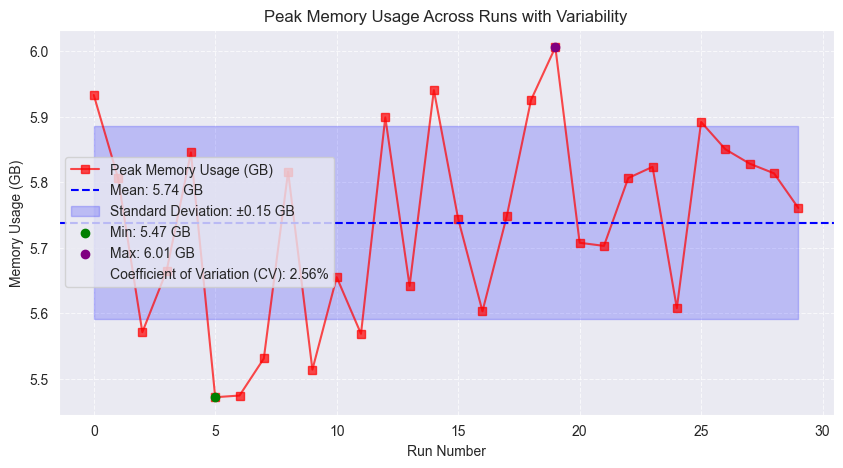

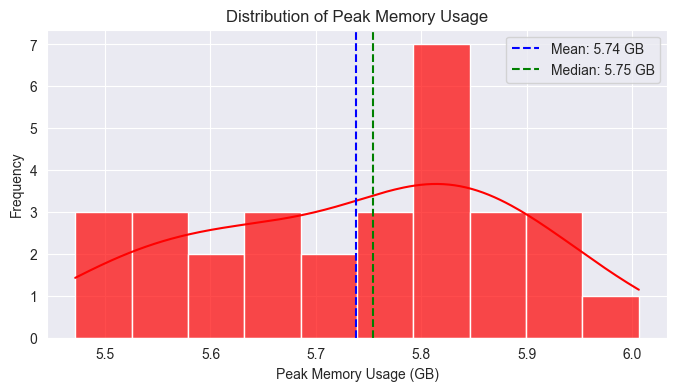

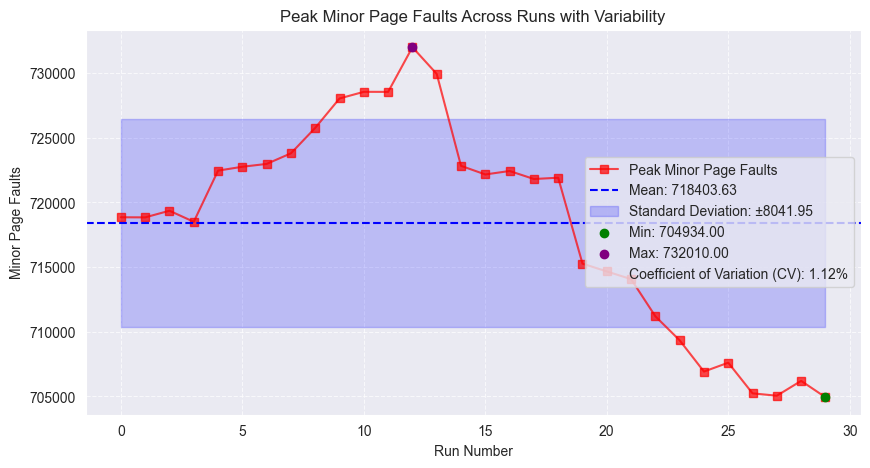

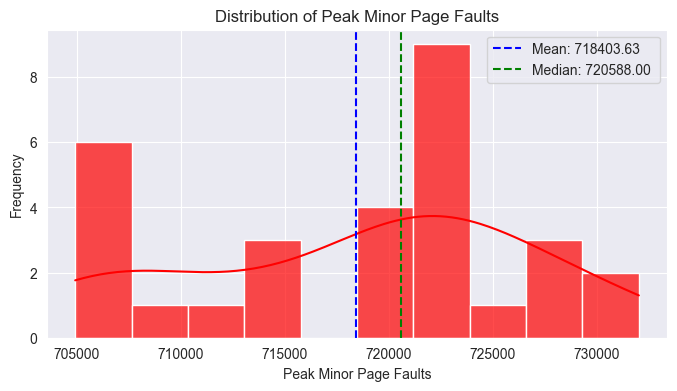

In [15]:
iterations = 30

memory_usage_history = []
page_faults_history = []

peak_memory_usage_history = []
peak_minor_page_faults_history = []
peak_major_page_faults_history = []

for i in range(iterations):
    memory_usage_log_file = f"docker-monitor/memory-usage--experiment-{i}-cpu-affinity.log"
    page_faults_log_file = f"docker-monitor/page-faults--experiment-{i}-cpu-affinity.log"

    logger.info(f"Iteration {i + 1}/{iterations}")
    experiment_container = client.containers.run(
        image=EXPERIMENT_IMAGE,
        mem_limit="15g",
        auto_remove=True,
        nano_cpus=int(1 * 1e9),  # Strictly allocate 1 CPU (1 * 1,000,000,000 nanoCPUs)
        cpu_shares=1024,  # Relative CPU priority
        cpuset_cpus="0",  # Pin to CPUs 0 for strict consistency
        command=[
            "operate",
            "envelope",
            "--segy-path", f"{CONTAINER_OUT_DIR}/data/{INLINES}-{XLINES}-{SAMPLES}.segy"
        ],
        environment={
            "MEMORY_USAGE_LOG_FILE": f"{CONTAINER_OUT_DIR}/{memory_usage_log_file}",
            "PAGE_FAULTS_LOG_FILE": f"{CONTAINER_OUT_DIR}/{page_faults_log_file}",
            "PAGE_FAULTS_MONITORED_PROCESS_NAME": "main.py operate",
        },
        volumes={
            os.path.abspath(f"../{RELATIVE_OUT_DIR}"): {
                "bind": CONTAINER_OUT_DIR,
                "mode": "rw",
            }
        },
    )

    memory_usage_df = tools.monitor.memory_usage_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{memory_usage_log_file}",
    )
    page_faults_df = tools.monitor.page_faults_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{page_faults_log_file}",
    )

    peak_memory_usage = tools.conversions.kb_to_gb(
        memory_usage_df["memory_usage_kb"].max()
    )
    peak_minor_page_faults = page_faults_df["minor_page_faults"].max()
    peak_major_page_faults = page_faults_df["major_page_faults"].max()

    memory_usage_history.append(memory_usage_df)
    page_faults_history.append(page_faults_df)

    peak_memory_usage_history.append(peak_memory_usage)
    peak_minor_page_faults_history.append(peak_minor_page_faults)
    peak_major_page_faults_history.append(peak_major_page_faults)

    logger.info("Peak memory usage: {} GB".format(peak_memory_usage))
    logger.info("Peak minor page faults: {}".format(peak_minor_page_faults))
    logger.info("Peak major page faults: {}".format(peak_major_page_faults))

plot_variability(peak_memory_usage_history, "Memory Usage", "GB")
plot_variability(peak_minor_page_faults_history, "Minor Page Faults")

As we can see, having CPU affinity drastically changed the page fault pattern.
Let's try merging the CPU affinity with the explicit drop of page caches.

2025-03-02 00:54:24.455 | INFO     | __main__:<module>:9 - Starting VFS Docker daemon...
2025-03-02 00:54:24.591 | INFO     | __main__:<module>:33 - Waiting for dockerd to start...
ERROR: error during connect: Get "http://localhost:2375/v1.47/info": read tcp [::1]:53440->[::1]:2375: read: connection reset by peer
2025-03-02 00:54:29.663 | INFO     | __main__:<module>:42 - Waiting for dockerd to start...
errors pretty printing info


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

ERROR: error during connect: Get "http://localhost:2375/v1.47/info": read tcp [::1]:53449->[::1]:2375: read: connection reset by peer
2025-03-02 00:54:34.750 | INFO     | __main__:<module>:42 - Waiting for dockerd to start...
errors pretty printing info


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

ERROR: error during connect: Get "http://localhost:2375/v1.47/info": read tcp [::1]:53460->[::1]:2375: read: connection reset by peer
errors pretty printing info
2025-03-02 00:54:39.831 | INFO     | __main__:<module>:42 - Waiting for dockerd to start...


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

[DEPRECATION NOTICE]: API is accessible on http://0.0.0.0:2375 without encryption.
         Access to the remote API is equivalent to root access on the host. Refer
         to the 'Docker daemon attack surface' section in the documentation for
         more information: https://docs.docker.com/go/attack-surface/
In future versions this will be a hard failure preventing the daemon from starting! Learn more at: https://docs.docker.com/go/api-security/
2025-03-02 00:54:44.917 | INFO     | __main__:<module>:39 - dockerd inside dind is fully operational.
2025-03-02 00:54:44.924 | INFO     | __main__:<module>:47 - Building experiment image...


Client: Docker Engine - Community
 Version:    27.3.1
 Context:    default
 Debug Mode: false
 Plugins:
  ai: Ask Gordon - Docker Agent (Docker Inc.)
    Version:  v0.7.3
    Path:     /Users/delucca/.docker/cli-plugins/docker-ai
  buildx: Docker Buildx (Docker Inc.)
    Version:  v0.20.1-desktop.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-buildx
  compose: Docker Compose (Docker Inc.)
    Version:  v2.32.4-desktop.1
    Path:     /Users/delucca/.docker/cli-plugins/docker-compose
  debug: Get a shell into any image or container (Docker Inc.)
    Version:  0.0.38
    Path:     /Users/delucca/.docker/cli-plugins/docker-debug
  desktop: Docker Desktop commands (Beta) (Docker Inc.)
    Version:  v0.1.4
    Path:     /Users/delucca/.docker/cli-plugins/docker-desktop
  dev: Docker Dev Environments (Docker Inc.)
    Version:  v0.1.2
    Path:     /Users/delucca/.docker/cli-plugins/docker-dev
  extension: Manages Docker extensions (Docker Inc.)
    Version:  v0.2.27
    Path:    

2025-03-02 00:55:57.245 | INFO     | __main__:<module>:52 - Experiment image built successfully.
2025-03-02 00:55:58.284 | INFO     | __main__:drop_caches_in_dind:18 - Dropped caches inside DinD container
2025-03-02 00:55:58.287 | INFO     | __main__:<module>:69 - Iteration 1/30
2025-03-02 00:56:05.495 | INFO     | tools.monitor:memory_usage_log_to_df:8 - Reading memory usage log) file: ../out/02-execution-environment-20250302003211/docker-monitor/memory-usage--experiment-0-without-page-caching+with-cpu-affinity.log
2025-03-02 00:56:05.498 | INFO     | tools.monitor:page_faults_log_to_df:28 - Reading page faults log file: ../out/02-execution-environment-20250302003211/docker-monitor/page-faults--experiment-0-without-page-caching+with-cpu-affinity.log
2025-03-02 00:56:05.499 | INFO     | __main__:<module>:116 - Peak memory usage: 5.434757232666016 GB
2025-03-02 00:56:05.500 | INFO     | __main__:<module>:117 - Peak minor page faults: 929711
2025-03-02 00:56:05.500 | INFO     | __main__:

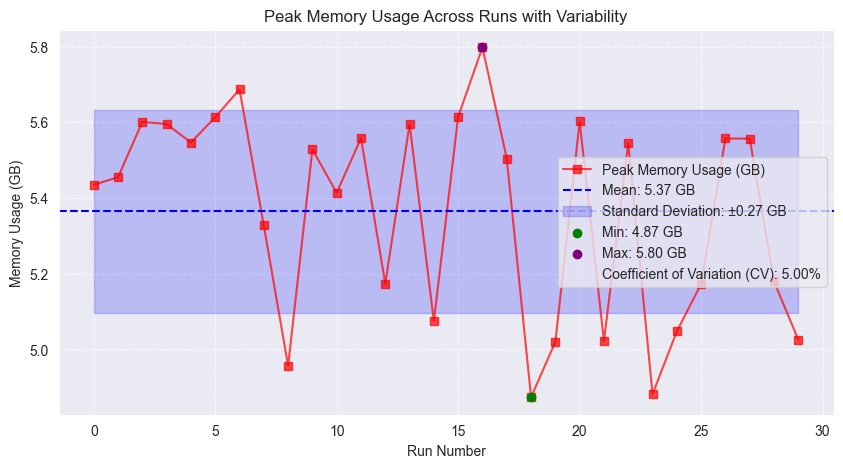

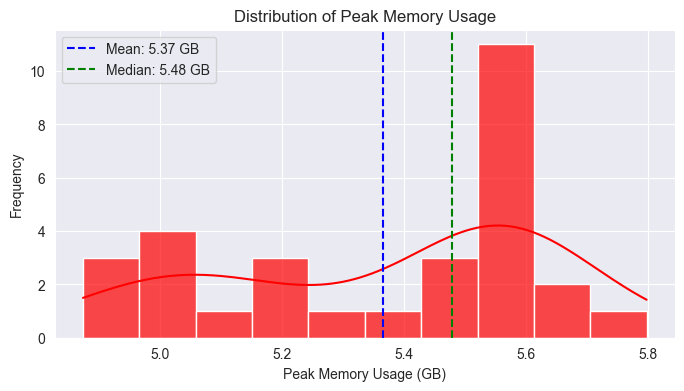

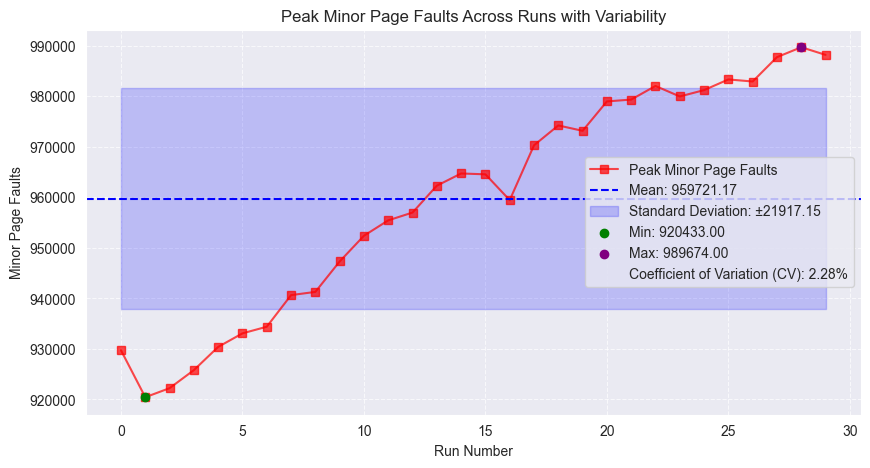

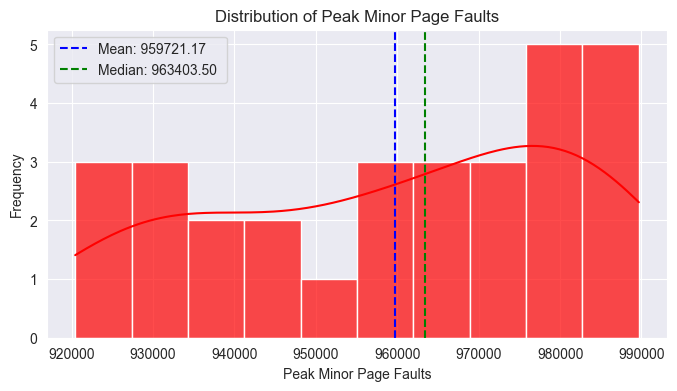

In [16]:
import subprocess
import time
import os

DIND_CONTAINER_NAME = "vfs-dind"
HOST_OUT_DIR = os.path.abspath(f"../{RELATIVE_OUT_DIR}")

logger.info("Starting VFS Docker daemon...")
vfs_container = client.containers.run(
    image="docker:dind",
    name=DIND_CONTAINER_NAME,
    auto_remove=True,
    privileged=True,
    detach=True,
    ports={
        "2375/tcp": 2375
    },
    command=[
        "--storage-driver=vfs"
    ],
    environment={
        "DOCKER_TLS_CERTDIR": "",
    },
    volumes={
        os.path.abspath(f"../{RELATIVE_OUT_DIR}"): {
            "bind": "/mnt/out",
            "mode": "rw",
        }
    },
)

logger.info("Waiting for dockerd to start...")
time.sleep(5)

for _ in range(10):
    try:
        subprocess.run(["docker", "-H", "tcp://localhost:2375", "info"], check=True)
        logger.info("dockerd inside dind is fully operational.")
        break
    except subprocess.CalledProcessError:
        logger.info("Waiting for dockerd to start...")
        time.sleep(5)

vfs_client = docker.DockerClient(base_url="tcp://localhost:2375")

logger.info("Building experiment image...")
experiment_image_build = vfs_client.images.build(
    path="../",
    tag=EXPERIMENT_IMAGE,
)
logger.info("Experiment image built successfully.")

iterations = 30

memory_usage_history = []
page_faults_history = []

peak_memory_usage_history = []
peak_minor_page_faults_history = []
peak_major_page_faults_history = []

for i in range(iterations):
    memory_usage_log_file = f"docker-monitor/memory-usage--experiment-{i}-without-page-caching+with-cpu-affinity.log"
    page_faults_log_file = f"docker-monitor/page-faults--experiment-{i}-without-page-caching+with-cpu-affinity.log"

    drop_caches_in_dind()

    logger.info(f"Iteration {i + 1}/{iterations}")

    experiment_container = vfs_client.containers.run(
        image=EXPERIMENT_IMAGE,
        mem_limit="15g",
        auto_remove=True,
        nano_cpus=int(1 * 1e9),  # Strictly allocate 1 CPU (1 * 1,000,000,000 nanoCPUs)
        cpu_shares=1024,  # Relative CPU priority
        cpuset_cpus="0",  # Pin to CPUs 0 for strict consistency
        command=[
            "operate",
            "envelope",
            "--segy-path", f"{CONTAINER_OUT_DIR}/data/{INLINES}-{XLINES}-{SAMPLES}.segy"
        ],
        environment={
            "MEMORY_USAGE_LOG_FILE": f"{CONTAINER_OUT_DIR}/{memory_usage_log_file}",
            "PAGE_FAULTS_LOG_FILE": f"{CONTAINER_OUT_DIR}/{page_faults_log_file}",
            "PAGE_FAULTS_MONITORED_PROCESS_NAME": "main.py operate",
        },
        volumes={
            "/mnt/out": {
                "bind": CONTAINER_OUT_DIR,
                "mode": "rw",
            }
        },
    )

    memory_usage_df = tools.monitor.memory_usage_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{memory_usage_log_file}",
    )
    page_faults_df = tools.monitor.page_faults_log_to_df(
        f"../{RELATIVE_OUT_DIR}/{page_faults_log_file}",
    )

    peak_memory_usage = tools.conversions.kb_to_gb(
        memory_usage_df["memory_usage_kb"].max()
    )
    peak_minor_page_faults = page_faults_df["minor_page_faults"].max()
    peak_major_page_faults = page_faults_df["major_page_faults"].max()

    memory_usage_history.append(memory_usage_df)
    page_faults_history.append(page_faults_df)

    peak_memory_usage_history.append(peak_memory_usage)
    peak_minor_page_faults_history.append(peak_minor_page_faults)
    peak_major_page_faults_history.append(peak_major_page_faults)

    logger.info("Peak memory usage: {} GB".format(peak_memory_usage))
    logger.info("Peak minor page faults: {}".format(peak_minor_page_faults))
    logger.info("Peak major page faults: {}".format(peak_major_page_faults))

vfs_container.stop()

plot_variability(peak_memory_usage_history, "Memory Usage", "GB")
plot_variability(peak_minor_page_faults_history, "Minor Page Faults")

## Summary of Findings

In this experiment, we aimed to evaluate the consistency of memory usage across multiple identical runs of a computational workload inside Docker containers.
Despite efforts to minimize variability, our findings indicate that even with strict resource constraints, Docker containers still exhibit memory fragmentation and other unpredictable memory behaviors.

### Key Findings

- Memory usage across runs showed non-trivial variability.
- Even running on containers, we still saw a decreasing amount of page faults between runs.
- Running with VFS storage-driver and dropping page cache helped reducing the contamination between runs.
- Running with CPU affinity helped reducing the contamination between runs.
- Memory fragmentation and page caching contamination persists, even with strict CPU affinity, VFS storage driver, and garbage collection optimizations.
- Docker’s memory allocation is not fully deterministic, likely due to:
  - Memory fragmentation inside the container.
  - Kernel-level caching effects that persist across container runs.
  - Variability in process startup behavior.

### Conclusions

Even under controlled conditions, Docker workloads experience small but persistent variations in memory usage due to fragmentation, kernel-level behaviors, and allocation inconsistencies.
While our optimizations improved consistency to a reasonable extent, achieving absolute determinism in memory usage remains challenging due to low-level system effects beyond Docker’s direct control.